In [3]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
import matplotlib.pyplot as plt
# force inline plots
%matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd

In [2]:
%run Generate_Training_Data.ipynb

The size of B:  1000000
The observed signal signal N (or bold X in the paper):  9
The observed luminosity:  30


In [4]:
theta, Z

(array([0.28447325, 0.81173861, 0.36367912, ..., 1.09171563, 2.21233192,
        0.94627533]),
 array([0, 0, 0, ..., 0, 0, 0]))

train_dataset[0]Now that we've built up the dataset, we now need to learn the function $\hat{p}(D;\theta)=\hat{p}(\theta)$ which is the output of a machine learning regression model, where the training data are $\vec{\theta}, \vec{Z}$ so that the target is $Z$ and the (input) features is $\theta$, so that the NN model's only parameter is $\theta$, not $D$ because it's just a fixed constant.
## Pytorch Regression Model

In [5]:
data, targets = theta, Z

In [6]:
ntargets = 1
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, 
                                                                      targets, 
                                                                      stratify=targets)
#Reshape the targets to have shape (something, 1)
train_targets = train_targets.reshape(-1,1)
test_targets = test_targets.reshape(-1,1)
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(test_targets, test_data)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]] [[4.00110329]
 [1.56452947]
 [0.04123302]
 ...
 [0.34008326]
 [0.3408608 ]
 [1.11956975]]


In [7]:
print(type(test_data), test_data.shape)

<class 'numpy.ndarray'> (250000, 1)


In [8]:
sc = StandardScaler()#this is always recommended for logistic regression
train_data= sc.fit_transform(train_data)
test_data = sc.transform(test_data)
train_data.mean(), (train_data.std())**2#check to make sure mean=0, std=1

(-1.5647098431751753e-16, 1.0)

In [9]:
class CustomDataset:
    """This takes the index for the data and target and gives dictionary of tensors of data and targets.
    For example we could do train_dataset = CustomDataset(train_data, train_targets); test_dataset = CustomDataset(test_data, test_targets)
 where train and test_dataset are np arrays that are reshaped to (-1,1).
 Then train_dataset[0] gives a dictionary of samples "X" and targets"""
    def __init__(self, data, targets):
        self.data = data
        self.targets=targets
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        current_sample = self.data[idx, :]
        current_target = self.targets[idx]
        return {"x": torch.tensor(current_sample, dtype = torch.float),
               "y": torch.tensor(current_target, dtype= torch.float),
               }#this already makes the targets made of one tensor (of one value) each
    
train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets)
train_dataset[0]

{'x': tensor([-0.0767]), 'y': tensor([0.])}

In [10]:

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=10, 
                                           num_workers=2, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=10, num_workers=2)

Compare with Directly computing the $p$-value for the Poisson distribution $PoisS(D|\lambda=\theta_0)$. So say we use counts $D=0....20$, then we have 20 jobs running in parallel, each working on a different value of $D$. It might be worth generalizing it so that the model is a parameterized function of both $\theta$ and $D$.

For our case, the goal is to generalize step 3, where we have 3 parameters as opposed to 1, $\theta =\{\sigma, \mathcal{L}, b \}$ so that we'd have priors for each of these parameters, so at the end, at a fixed $D$, we'd have the output being the p-value being a function of all 3 $\hat{p}(D; \sigma, \mathcal{L}, b)$. Then we can use section 3.4 to construct the confidence interval for the cross section that properly takes into account the two nuissance parameters $\mathcal{L}, b$

In [11]:
# from mymodels import RegressionModel
class RegressionModel(nn.Module):
    #inherit from the super classdddddddddddd
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 
        
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)
            
    
    def forward(self, x):
        return self.model(x)

In [12]:
model =  RegressionModel(nfeatures=train_data.shape[1], 
               ntargets=1,
               nlayers=5, 
               hidden_size=128, 
               dropout=0.3)
print(model)

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, 

In [13]:
class RegressionEngine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    @staticmethod
    def loss_fun(targets, outputs):
         return nn.MSELoss()(outputs, targets)


    def train(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for data in data_loader:
            self.optimizer.zero_grad()#only optimize weights for the current batch, otherwise it's meaningless!
            inputs = data["x"]
            targets = data["y"]
            outputs = self.model(inputs)
            loss = self.loss_fun(targets, outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            return final_loss / len(data_loader)

    
    def evaluate(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for data in data_loader:
            inputs = data["x"]#.to(self.device)
            targets = data["y"]#.to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fun(targets, outputs)
            final_loss += loss.item()
            return outputs
            #return final_loss / len(data_loader)

In [49]:
def train(optimizer, engine, early_stopping_iter, epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    eng = RegressionEngine(model=model, optimizer = optimizer)
    best_loss = np.inf
    early_stopping_iter = 10
    early_stopping_counter = 0
    EPOCHS=22
    for epoch in range(EPOCHS):
        train_loss = eng.train(train_loader)
        test_loss = eng.train(test_loader)
        print("Epoch : %-10g, Training Loss: %-10g, Test Loss: %-10g" % (epoch, train_loss, test_loss))
        #print(f"{epoch}, {train_loss}, {test_loss}")
        if test_loss < best_loss:
            best_loss = test_loss

        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_iter:
            #if we are not improving for 10 iterations then break the loop
            #we could save best model here
            break

In [50]:
optimizer = torch.optim.Adam(model.parameters())
train(optimizer, engine =RegressionEngine(model=model, optimizer = optimizer),
      early_stopping_iter = 10,
      epochs=22)

Epoch : 0         , Training Loss: 3.98226e-07, Test Loss: 8.61863e-07
Epoch : 1         , Training Loss: 3.64439e-07, Test Loss: 7.7058e-07
Epoch : 2         , Training Loss: 3.61309e-07, Test Loss: 7.70726e-07
Epoch : 3         , Training Loss: 2.86147e-07, Test Loss: 7.24303e-07
Epoch : 4         , Training Loss: 1.74792e-07, Test Loss: 6.36877e-07
Epoch : 5         , Training Loss: 1.86181e-07, Test Loss: 4.17103e-07
Epoch : 6         , Training Loss: 1.59721e-07, Test Loss: 4.32235e-07
Epoch : 7         , Training Loss: 1.2331e-07, Test Loss: 3.45689e-07
Epoch : 8         , Training Loss: 1.47526e-07, Test Loss: 3.89183e-07
Epoch : 9         , Training Loss: 7.61074e-08, Test Loss: 3.42965e-07
Epoch : 10        , Training Loss: 1.31316e-07, Test Loss: 2.28732e-07
Epoch : 11        , Training Loss: 1.42312e-07, Test Loss: 1.6924e-07
Epoch : 12        , Training Loss: 6.74564e-08, Test Loss: 1.09543e-07
Epoch : 13        , Training Loss: 9.77996e-08, Test Loss: 1.45653e-07
Epoch : 1

In [51]:
from IPython.core.debugger import set_trace

In [16]:
def predict():
    outputs = []
    labels = []
    accuracies = []

    #evaluate
    with torch.no_grad():
        for data in test_loader:
            data_cp = copy.deepcopy(data)

            xtest = data_cp["x"]
            ytest = data_cp["y"]
            output = model(xtest)
            labels.append(ytest)
            outputs.append(output)

            y_predicted_cls = output.round()
            acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])#bumber of correct predictions/sizeofytest
            #accuracies.append(acc.numpy())
            #print(f'accuracy: {acc.item():.4f}')

            del data_cp

    #     acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])
    #     print(f'accuracy: {acc.item():.4f}')
            
    OUTPUTS = torch.cat(outputs).view(-1).numpy()

    LABELS = torch.cat(labels).view(-1).numpy()
    print('outputs of model: ', OUTPUTS)
    print('\nactual labels (targets Z): ', LABELS)
    return OUTPUTS, LABELS

In [17]:
OUTPUTS, LABELS = predict()

outputs of model:  [0.06671236 0.13141686 0.13383634 ... 0.1803793  0.11944921 0.23281641]

actual labels (targets Z):  [0. 0. 0. ... 0. 0. 0.]


In [18]:
OUTPUTS.shape , LABELS.shape

((250000,), (250000,))

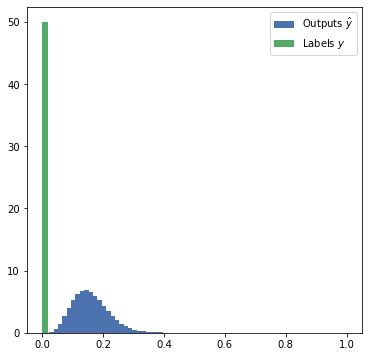

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(OUTPUTS, bins=50, density=True, label = "Outputs $\hat{y}$")
plt.hist(LABELS, bins=50,density=True, label = "Labels $y$")
plt.legend()
plt.show()

In [36]:
def calc_prob_1(model, X):
    X = torch.from_numpy(X).float()
    model.eval()
    P_y_equals_1 = model(X)
    P_y_equals_1 = P_y_equals_1.squeeze()
    return P_y_equals_1.detach().numpy().flatten()#detaches it from the computational history/prevent future computations from being tracked

In [37]:
P_Z_equals_1 = calc_prob_1(model, test_data)

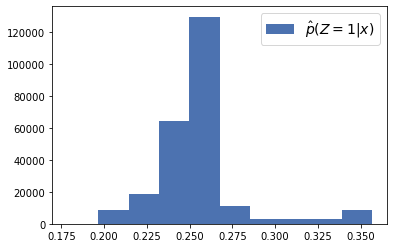

In [38]:
plt.hist(P_Z_equals_1, label='$\hat{p}(Z=1|x)$')
plt.legend(fontsize=14)

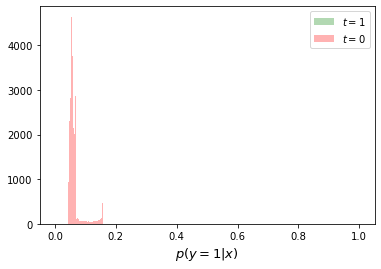

In [26]:
plt.hist(p[p>0.5], bins=50, color='g',
            histtype='stepfilled',
            alpha=0.3,label = '$t = 1$')

plt.hist(p[p<0.5], bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3,label = '$t = 0$')
plt.xlabel('$p(y=1|x)$', fontsize=13)
plt.legend()

st.expon.rvs(size=len(test_data))The actual p-value is $p = \int P(N|\theta) d\theta$ or in our case $p=\sum_{k=D+1}^{\infty} \text{Poisson}(k|\theta) = scipy.special.gammainc(D, \theta)$

In [39]:
D=9
def p_calculated(theta):
    p_computed = sp.special.gammainc(D, theta)
    p_computed = np.array(p_computed)
    return p_computed

In [40]:
p_calc = p_calculated(10); type(p_calc)

numpy.ndarray

In [41]:
type(st.expon.rvs(size=4))

numpy.ndarray

In [44]:
len(test_data), type(test_data)

(250000, numpy.ndarray)

In [56]:
th = st.expon.rvs(size=len(test_data)) 
#th = torch.from_numpy(th)
print(th.shape, type(th))

(250000,) <class 'numpy.ndarray'>


I might need to write a validation script with no_grad()

In [ ]:
def infer(model, theta):
    model.eval()

In [57]:
p_hat = calc_prob_1(model, th); p_hat.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x250000 and 1x128)

In [44]:
def compare_p_values(model):
    theta = st.expon.rvs(size=len(test_data))
    
    p_hat = compute_prob(model, theta)#model evaluated at theta
    p_calculated = [p_calculated(theta = theta[i]) for i in range(len(theta))]
    
    plt.hist(p_hat, label = r'$\hat{p}$', alpha=0.3)
    plt.hist(p_calculated, label='$p$ calculated', alpha=0.3)
    plt.legend()
    

In [45]:
compare_p_values(model=model)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x25000 and 1x128)

In [ ]:
def Algorithm2(D=2, theta_0):
    
    
    
    return actual_p_value, regressed_p_value

In [83]:
def E_hat(T):
    """The expectation value of Z as a relative frequency, this should equal p_hat, the learned parameterized distribution at a given theta"""
    num = np.array(T[1]).sum()
    den = Bprime
    return num/den